In [2]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import pandas as pd
from omegaconf import OmegaConf
from pathlib import Path
from pprint import pprint
# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
# mycode
from repo import REPO
from ml_utilities.output_loader.result_loader import SweepResult, JobResult
from ml_utilities.output_loader import create_job_output_loader
from ml_utilities.output_loader.plot import plot_sweep_summary, plot_data_log_values
import tflearning
from tflearning.sample_difficulty.el2n_grand_scores import El2nAndGrandScores
import pickle

# 30 CIFAR10 EL2N runs

This notebook is used to implement the EL2N  nd the GraNd scores

## A. Experiment config

### Config file

In [3]:
config_yaml = """
run_config:
  exec_type: parallel
  hostname: scorpion
  gpu_ids: [0,1,2,3]
  runs_per_gpu: 2
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      - run_handler
      notes: null
      group: ${config.experiment_data.experiment_tag}
      job_type: run_handler

seeds: [0,1,2,3,4,5,6,7,8,9]

sweep:
  type: skip
  axes: 

    
start_num: 1

config:
  experiment_data:
    entity: fslgroup
    project_name: tflearning
    experiment_tag: '30-cf10-el2n'
    experiment_type: startnum_${start_num}
    experiment_name: cifar10-${config.experiment_data.experiment_tag}.${start_num}-resnet18
    experiment_dir: null
    experiment_notes: 
    seed: 0
    gpu_id: 0
  
  model:
    name: timmmodel
    kwargs:
      name: resnet18
      timm_kwargs:
        pretrained: False
  
  trainer:
    training_setup: finetune
    n_epochs: 30
    save_every: 10
    val_every: 1
    early_stopping_patience: 30
    batch_size: 128
    optimizer:
      name: SGD
      kwargs:
        lr: 0.1
        weight_decay: 0.0005
        momentum: 0.9
    loss: crossentropy
    num_workers: 4
  
  data:
    name: cifar10
    kwargs:
      data_root_path: /system/user/beck/pwbeck/data #/local00/bioinf/beck/data #
      n_px: 32
"""
cfg = OmegaConf.create(config_yaml)

In [4]:
# run_command = REPO.create_experiment(cfg, override=False)
# print(run_command)

In [5]:
sweepr = REPO.get_output_loader(cfg)
print(sweepr)

Exp. Tag(start_num): 30-cf10-el2n(1)
Exp. Name: cifar10-30-cf10-el2n.1-resnet18
Training setup: finetune
Model name: timmmodel
Dataset name: cifar10
Sweep type: skip
  No sweep axes.
Seeds: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Num. jobs: 10
Config updated: 2023-03-22 09:58:04
Sweep started:  2023-03-22 09:58:21



In [6]:
sweepr.directory

PosixPath('/system/user/publicwork/beck/projects/regularization/tflearning/outputs/cifar10-30-cf10-el2n.1-resnet18--230322_095821')

In [7]:
failed_jobs = sweepr.get_failed_jobs()
failed_jobs # No failed jobs

([], {})

In [8]:
sw_summary = sweepr.get_summary(log_source='val', col_sel='Accuracy-top-1', row_sel=('epoch', 20))

In [9]:
sw_summary

,best_epoch,best_val_score,Accuracy-top-1-epoch-20,seed
cifar10-30-cf10-el2n.1-resnet18---seed-0--230322_095844,28,0.709097,0.7395,0
cifar10-30-cf10-el2n.1-resnet18---seed-1--230322_095847,27,0.728892,0.7448,1
cifar10-30-cf10-el2n.1-resnet18---seed-2--230322_095851,30,0.708047,0.7336,2
cifar10-30-cf10-el2n.1-resnet18---seed-3--230322_095853,26,0.693980,0.7409,3
cifar10-30-cf10-el2n.1-resnet18---seed-4--230322_095855,26,0.693217,0.7396,4
cifar10-30-cf10-el2n.1-resnet18---seed-5--230322_095856,27,0.658748,0.7423,5
cifar10-30-cf10-el2n.1-resnet18---seed-6--230322_095857,24,0.688411,0.7466,6
cifar10-30-cf10-el2n.1-resnet18---seed-7--230322_095858,22,0.710099,0.7242,7
cifar10-30-cf10-el2n.1-resnet18---seed-8--230322_100754,26,0.672588,0.7250,8
cifar10-30-cf10-el2n.1-resnet18---seed-9--230322_100755,29,0.660837,0.7286,9


### EL2N Scores for CIFAR10 at after epoch 20

In [10]:
score_computer = El2nAndGrandScores(sweepr, compute_at_progress_idx=20, compute_grand=False)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
# scores = score_computer.compute()

In [13]:
def load_dict(path):
    with open(path, 'rb') as f:
        d = pickle.load(f)
    return d

In [14]:
sweepr.directory / 'el2n_grand_scores_230322_215521.p'

PosixPath('/system/user/publicwork/beck/projects/regularization/tflearning/outputs/cifar10-30-cf10-el2n.1-resnet18--230322_095821/el2n_grand_scores_230322_215521.p')

In [15]:
el2n_grand_scores = load_dict(sweepr.directory / 'el2n_grand_scores_230322_215521.p')

(array([3.397e+03, 2.712e+03, 2.432e+03, 2.066e+03, 1.952e+03, 1.813e+03,
        1.736e+03, 1.582e+03, 1.546e+03, 1.526e+03, 1.442e+03, 1.409e+03,
        1.351e+03, 1.262e+03, 1.244e+03, 1.212e+03, 1.206e+03, 1.228e+03,
        1.157e+03, 1.114e+03, 1.139e+03, 1.061e+03, 1.042e+03, 1.047e+03,
        9.560e+02, 9.610e+02, 9.460e+02, 9.180e+02, 8.480e+02, 8.320e+02,
        7.980e+02, 7.990e+02, 7.210e+02, 6.850e+02, 6.220e+02, 6.080e+02,
        5.650e+02, 4.630e+02, 4.170e+02, 3.760e+02, 2.650e+02, 1.960e+02,
        1.320e+02, 9.700e+01, 4.700e+01, 3.500e+01, 2.000e+01, 8.000e+00,
        7.000e+00, 2.000e+00]),
 array([1.18800184e-04, 2.83297580e-02, 5.65407164e-02, 8.47516730e-02,
        1.12962633e-01, 1.41173586e-01, 1.69384554e-01, 1.97595507e-01,
        2.25806460e-01, 2.54017413e-01, 2.82228380e-01, 3.10439348e-01,
        3.38650286e-01, 3.66861254e-01, 3.95072222e-01, 4.23283160e-01,
        4.51494128e-01, 4.79705095e-01, 5.07916033e-01, 5.36127031e-01,
        5.643379

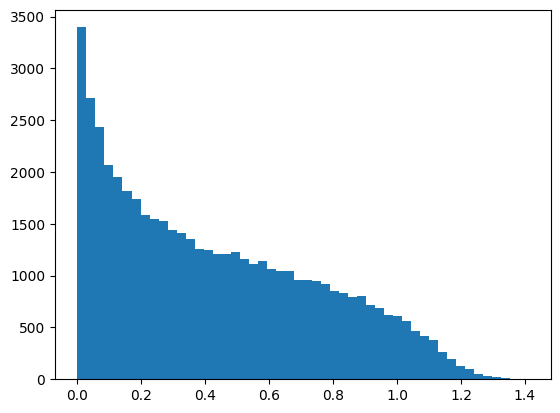

In [ ]:
plt.hist(el2n_grand_scores['el2n']['average'], bins=50)

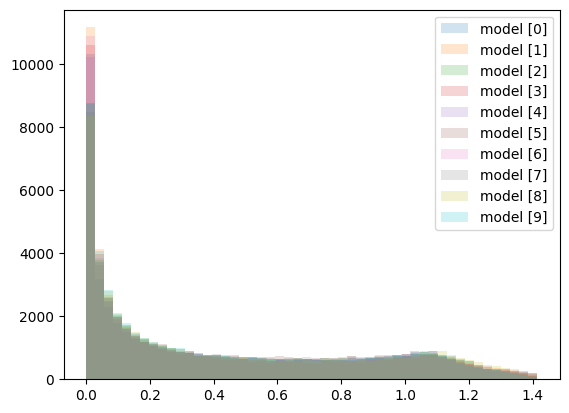

In [ ]:
for i, score in enumerate(el2n_grand_scores['el2n']['single_runs'].values()):
    f = plt.hist(score, bins=50, label=f'model [{i}]', alpha=0.2)

plt.legend()

## GraNd scores

(array([1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 1.100e+01, 1.900e+01,
        2.300e+01, 4.300e+01, 6.900e+01, 1.520e+02, 1.880e+02, 2.980e+02,
        3.810e+02, 5.670e+02, 7.640e+02, 9.500e+02, 1.180e+03, 1.477e+03,
        1.778e+03, 1.976e+03, 2.365e+03, 2.629e+03, 2.879e+03, 2.976e+03,
        2.994e+03, 2.927e+03, 2.918e+03, 2.616e+03, 2.372e+03, 2.147e+03,
        1.884e+03, 1.647e+03, 1.473e+03, 1.276e+03, 1.038e+03, 9.750e+02,
        8.570e+02, 7.190e+02, 6.400e+02, 6.080e+02, 5.490e+02, 4.370e+02,
        4.300e+02, 3.290e+02, 2.280e+02, 1.120e+02, 6.600e+01, 2.100e+01,
        6.000e+00, 2.000e+00]),
 array([1.97725612, 2.07635302, 2.17544992, 2.27454682, 2.37364372,
        2.47274062, 2.57183752, 2.67093442, 2.77003132, 2.86912822,
        2.96822512, 3.06732202, 3.16641892, 3.26551582, 3.36461272,
        3.46370962, 3.56280652, 3.66190341, 3.76100031, 3.86009721,
        3.95919411, 4.05829101, 4.15738791, 4.25648481, 4.35558171,
        4.45467861, 4.55377551, 4.65

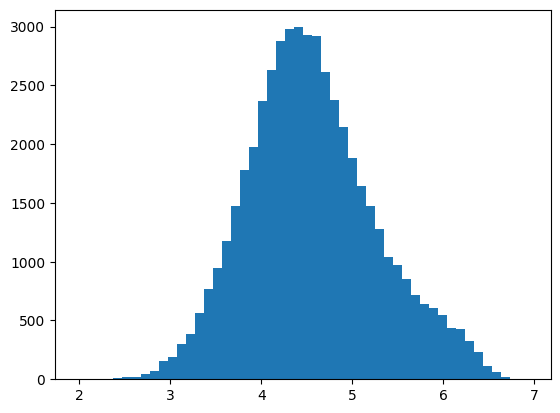

In [ ]:
plt.hist(el2n_grand_scores['grand']['average'], bins=50)

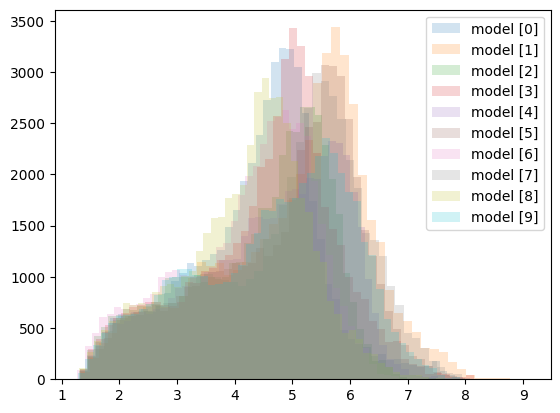

In [ ]:
for i, score in enumerate(el2n_grand_scores['grand']['single_runs'].values()):
    f = plt.hist(score, bins=50, label=f'model [{i}]', alpha=0.2)

plt.legend()